In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_set = pd.read_csv('../input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

In [3]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
# 訓練/テストに分割 (層化なし)
train_set, test_set = train_test_split(data_set, train_size=0.7, random_state=42)
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [5]:
# リークを防ぐ
test_target = test_set['Target']
test_set['Target'] = np.nan
test_failure_type = test_set['Failure Type']
test_set['Failure Type'] = np.nan

# データの分析と可視化

In [6]:
train_set

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,9070,M23929,M,297.2,308.2,1678,28.1,133,0,No Failure
1,2604,M17463,M,299.3,309.2,1334,46.3,31,0,No Failure
2,7739,M22598,M,300.5,312.0,1263,60.8,146,0,No Failure
3,1580,L48759,L,298.3,308.3,1444,43.8,176,0,No Failure
4,5059,L52238,L,303.9,312.9,1526,42.5,194,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
6995,5735,L52914,L,302.3,311.8,1369,56.2,208,1,Overstrain Failure
6996,5192,L52371,L,304.0,313.2,1416,46.0,128,0,No Failure
6997,5391,H34804,H,302.8,312.3,1483,47.2,223,0,No Failure
6998,861,H30274,H,296.1,306.9,1541,32.6,33,0,No Failure


0.035


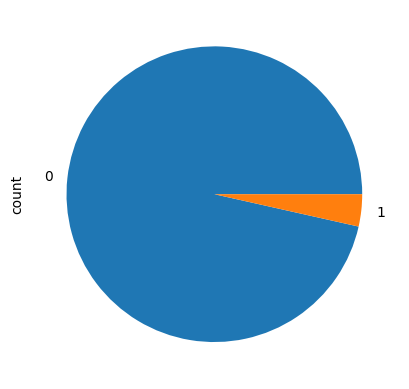

In [7]:
# 障害発生率
train_set['Target'].value_counts().plot.pie()
print('{:.3f}'.format(train_set['Target'].mean()))

L failure rate:   0.040
M failure rate:   0.033
H failure rate:   0.015


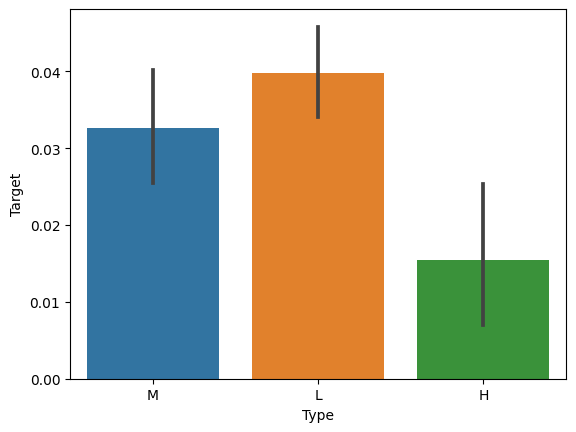

In [8]:
# Typeごとの障害発生率
sns.barplot(x='Type', y='Target', data=train_set)
print('L failure rate:   {:.3f}'.format(train_set['Target'][train_set.Type=='L'].mean()))
print('M failure rate:   {:.3f}'.format(train_set['Target'][train_set.Type=='M'].mean()))
print('H failure rate:   {:.3f}'.format(train_set['Target'][train_set.Type=='H'].mean()))

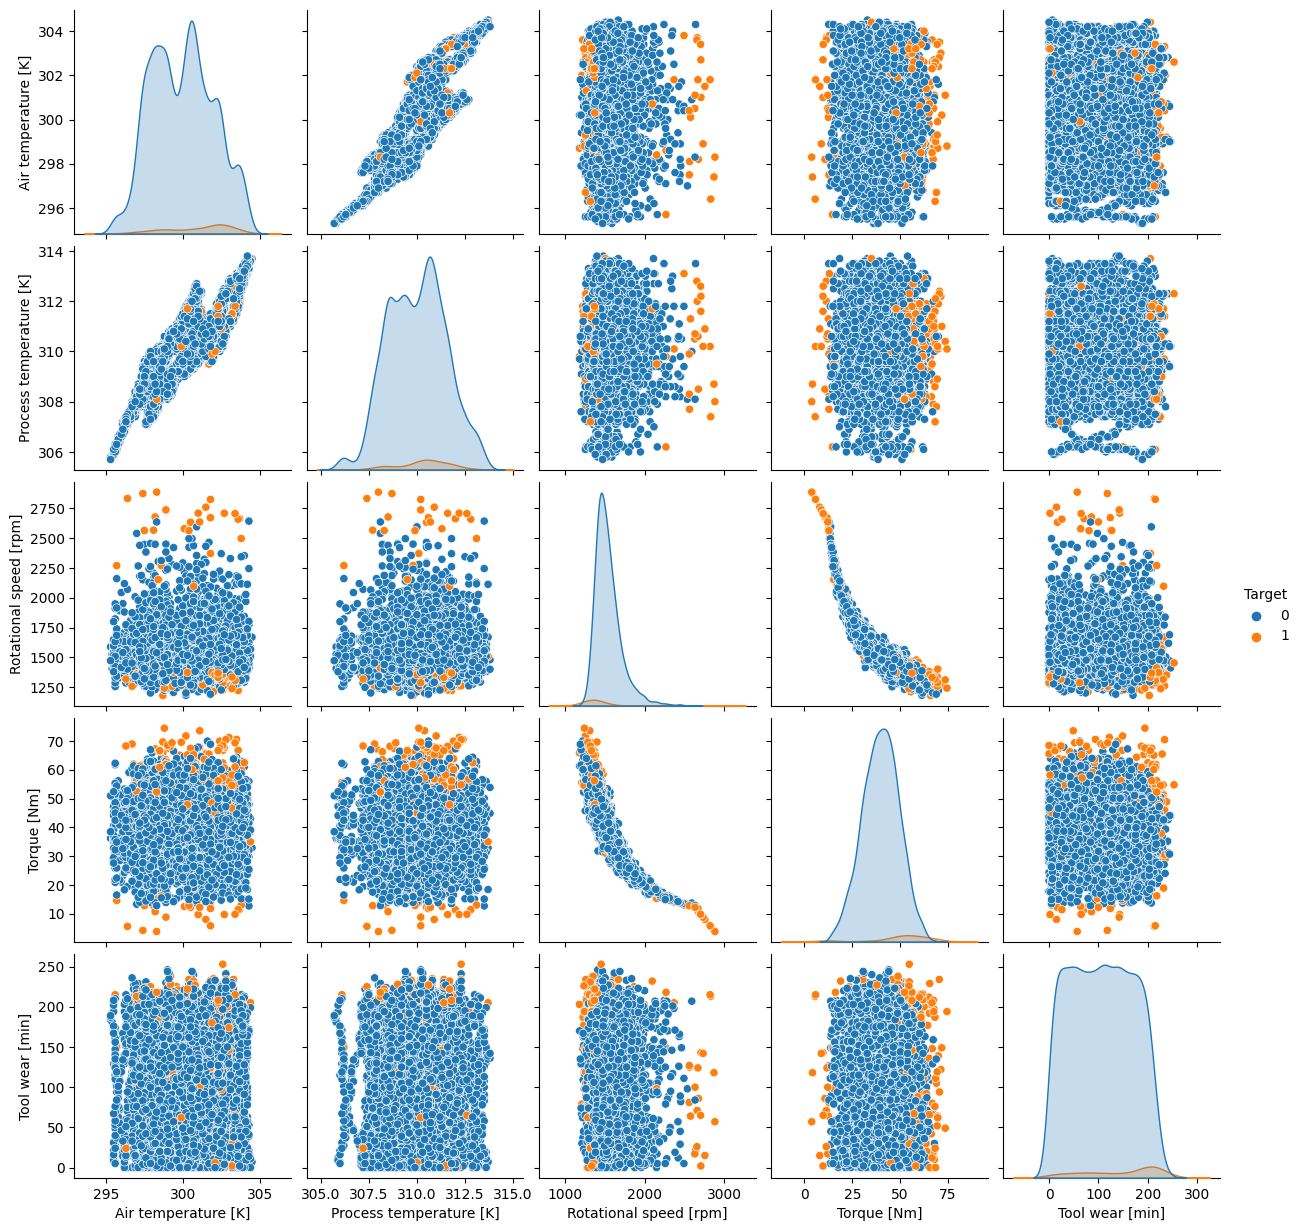

In [9]:
# ペアプロット
continuous = train_set.loc[:, 'Air temperature [K]':'Target']
sns.pairplot(continuous, vars=continuous.columns[:-1], hue=continuous.columns[-1])

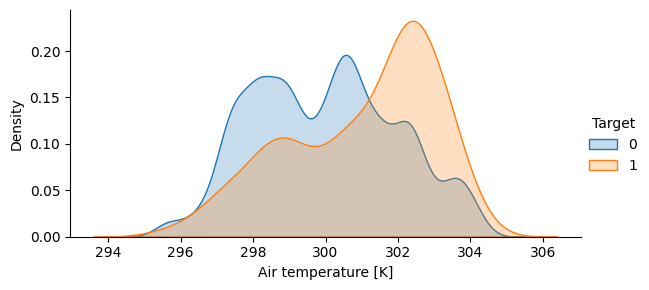

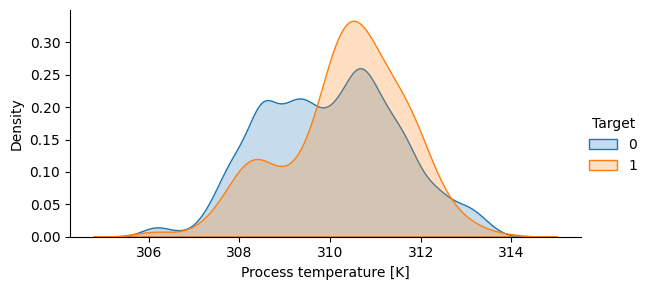

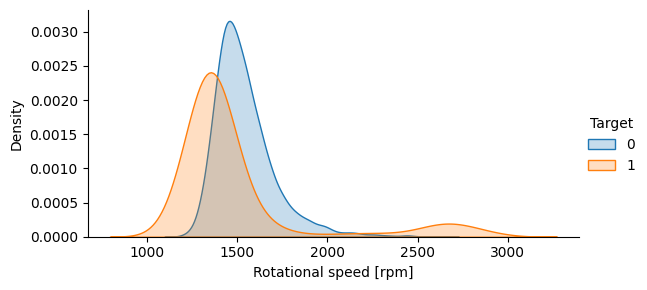

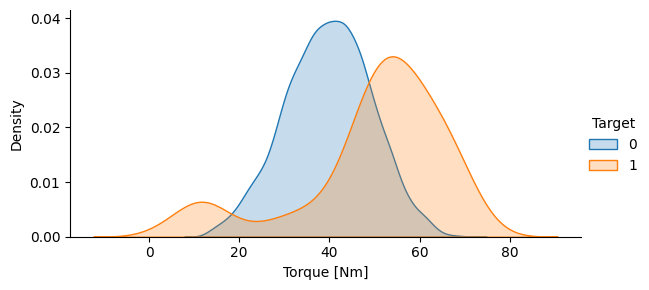

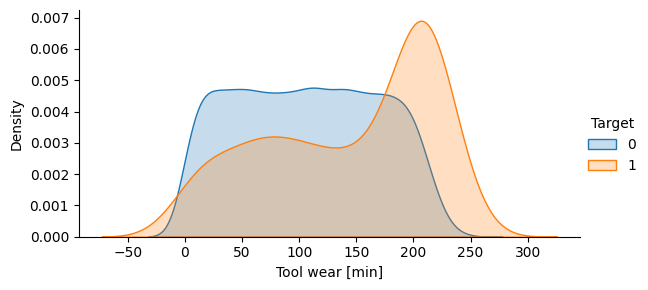

In [10]:
for x in continuous.columns[:-1]:
    kernel = sns.FacetGrid(train_set, hue="Target", aspect=2)
    kernel.map(sns.kdeplot, x, shade= True)
    kernel.add_legend()

# データ変換と学習・予測

In [11]:
# ワンホットエンコーディング
data = pd.concat([train_set, test_set])
data = pd.get_dummies(data.loc[:, 'Type':'Target'])
data

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_H,Type_L,Type_M
0,297.2,308.2,1678,28.1,133,0.0,False,False,True
1,299.3,309.2,1334,46.3,31,0.0,False,False,True
2,300.5,312.0,1263,60.8,146,0.0,False,False,True
3,298.3,308.3,1444,43.8,176,0.0,False,True,False
4,303.9,312.9,1526,42.5,194,0.0,False,True,False
...,...,...,...,...,...,...,...,...,...
2995,300.9,312.0,1500,44.2,188,NaN,False,True,False
2996,297.0,307.9,1595,31.7,170,NaN,False,True,False
2997,300.0,309.1,1431,45.4,90,NaN,False,True,False
2998,300.6,309.8,1541,36.2,166,NaN,True,False,False


In [12]:
# スケール化
data.loc[:, 'Air temperature [K]':'Tool wear [min]'] = MinMaxScaler().fit_transform(data.loc[:, 'Air temperature [K]':'Tool wear [min]'])
data.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7000.000000
mean,0.511405,0.531551,0.215818,0.497073,0.426684,0.035143
std,0.217419,0.183177,0.104356,0.136936,0.251597,0.184154
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.326087,0.382716,0.148428,0.403846,0.209486,0.000000
50%,0.521739,0.543210,0.194994,0.498626,0.426877,0.000000
75%,0.673913,0.666667,0.258440,0.590659,0.640316,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# データ分割
train = data[data.Target.notna()]
test = data[data.Target.isna()]
del test['Target']

# 訓練データを特徴量/ターゲットに分割
X = train.drop(['Target'], axis=1)
y = train.Target

In [14]:
# パイプライン
# 不均衡データに対する重みづけ
# class_weight='balanced':【クラスXの重み】=【全データ数】/ (【クラス数】*【クラスXのデータ数】)
pipe = Pipeline([('classify', RandomForestClassifier(random_state=10, max_features='sqrt', class_weight='balanced'))])
param_test = {'classify__n_estimators': list(range(10, 14, 1)),
              'classify__max_depth': list(range(1, 3, 1))}

# グリッドサーチ
grid = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='recall', cv=10)
grid.fit(X, y)
print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))

best_params_: {'classify__max_depth': 2, 'classify__n_estimators': 13}
best_score_: 0.854


In [15]:
# 正解率
predict = grid.predict(test)
print('predict_score:   {:.3f}'.format(accuracy_score(test_target, predict)))
print('all_zero_score:  {:.3f}\n'.format(accuracy_score(test_target, np.array([0]*test.shape[0]))))

# 再現率
print('predict_recall:  {:.3f}'.format(recall_score(test_target, predict)))
print('all_zero_recall: {:.3f}'.format(recall_score(test_target, np.array([0]*test.shape[0]))))

predict_score:   0.852
all_zero_score:  0.969

predict_recall:  0.806
all_zero_recall: 0.000


In [16]:
# Classification Report
print(classification_report(test_target, predict))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      2907
           1       0.15      0.81      0.25        93

    accuracy                           0.85      3000
   macro avg       0.57      0.83      0.59      3000
weighted avg       0.97      0.85      0.90      3000



In [17]:
# スレッショルドを下げて再現率を上げる
# 不均衡の重みを付けなかった場合, スレッショルドを0.1まで下げても再現率は0.85だったが,
# 不均衡の重みを付けた場合、スレッショルドを0.26まで下げることで再現率を1まで引き上げられた (一方で適合率は著しく低下).
predict_recall = grid.predict_proba(test)[:, 1] > 0.26
print('recall:    {:.3f}'.format(recall_score(test_target, predict_recall)))
print('precision: {:.3f}'.format(precision_score(test_target, predict_recall)))

recall:    1.000
precision: 0.043


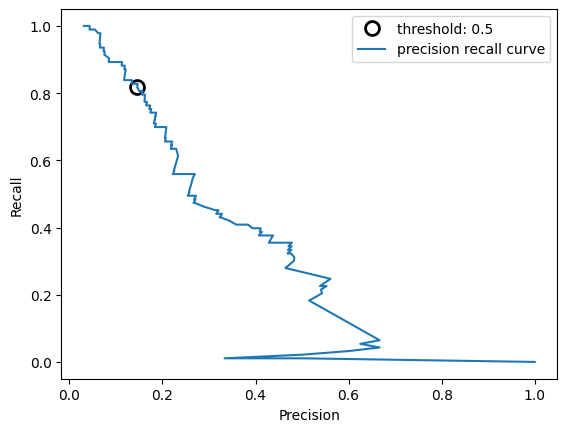

In [18]:
# 適合率-再現率カーブ
precision, recall, thresholds = precision_recall_curve(test_target, grid.predict_proba(test)[:, 1])
close_zero = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold: 0.5", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")